In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape
from darts.datasets import EnergyDataset
from darts import concatenate

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import logging
logging.disable(logging.CRITICAL)

In [4]:
def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [5]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(12, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "MAPE: {}".format(mape(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

,Monthly Anamoly
DateTime,
1880-01-01,1.836
1880-02-01,4.134
1880-03-01,8.959
1880-04-01,13.445
1880-05-01,20.229


Text(0.5, 1.0, 'Shanghai Temp')

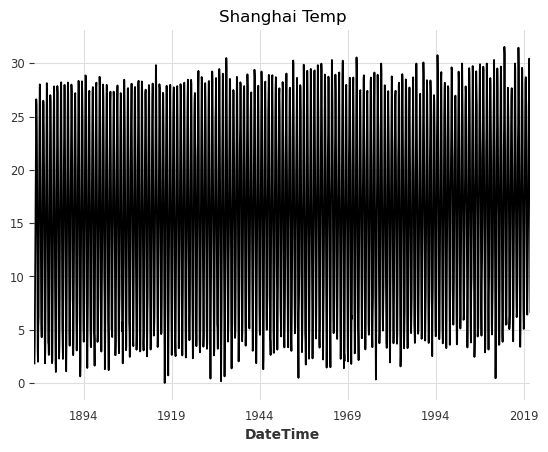

In [6]:
rawdata = pd.read_csv("../data/all_cities_month_temp_df.csv")
rawdata = rawdata.loc[rawdata.loc[:,"city_num"] == 1]
rawdata["DateTime"] = rawdata["year"].astype('str') + '-' + rawdata["month"].astype('str')
rawdata = rawdata.loc[:,["DateTime", "Monthly Anamoly"]]
rawdata["DateTime"] = pd.to_datetime(rawdata["DateTime"])
rawdata = rawdata.loc[rawdata['DateTime'] >= '1880-01-01']
rawdata.set_index("DateTime", inplace=True, drop=True)
display(rawdata.head())

rawdata["Monthly Anamoly"].plot()
plt.title("Shanghai Temp")

In [7]:
series = TimeSeries.from_dataframe(rawdata).astype(np.float32)
scaler = Scaler()
train = series
# train, val = series.split_after(pd.Timestamp("20141201"))

Text(0.5, 1.0, 'Shanghai Temp')

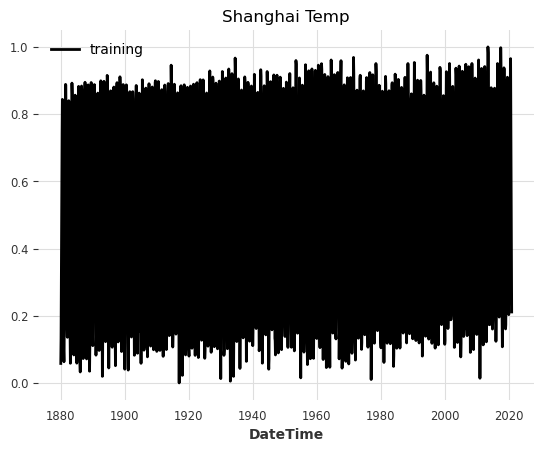

In [8]:
train_scaled = scaler.fit_transform(train)
# val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

train_scaled.plot(label="training")
# val_scaled.plot(label="val")
plt.title("Shanghai Temp")

In [9]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=480,
    output_chunk_length=60,
    generic_architecture=False,
    num_blocks=7,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=64,
    random_state=156,
    model_name=model_name,
    # save_checkpoints=True,
    # force_reset=True,
    **generate_torch_kwargs(),
)

In [10]:
model_nbeats.fit(train_scaled)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=False, num_stacks=30, num_blocks=7, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=480, output_chunk_length=60, n_epochs=100, nr_epochs_val_period=1, batch_size=64, random_state=156, model_name=nbeats_run, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x2a66a04f0>]})

In [11]:
#model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

In [12]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=pd.Timestamp('2005-01-01'),
    forecast_horizon=60,
    stride=1,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

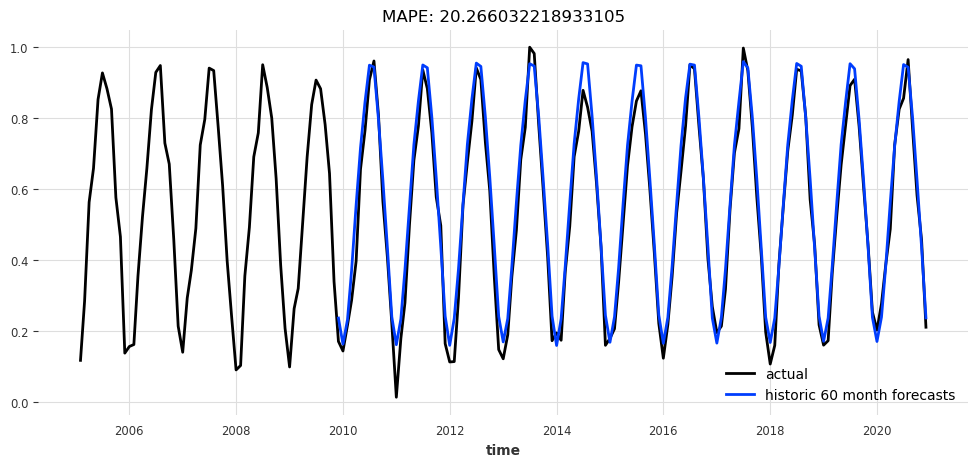

In [13]:
display_forecast(
    pred_series,
    series_scaled,
    "60 month",
    start_date=pd.Timestamp('2005-01-01'),
)

In [14]:
pred_series = model_nbeats.predict(12*80)
pred_series = concatenate(pred_series)

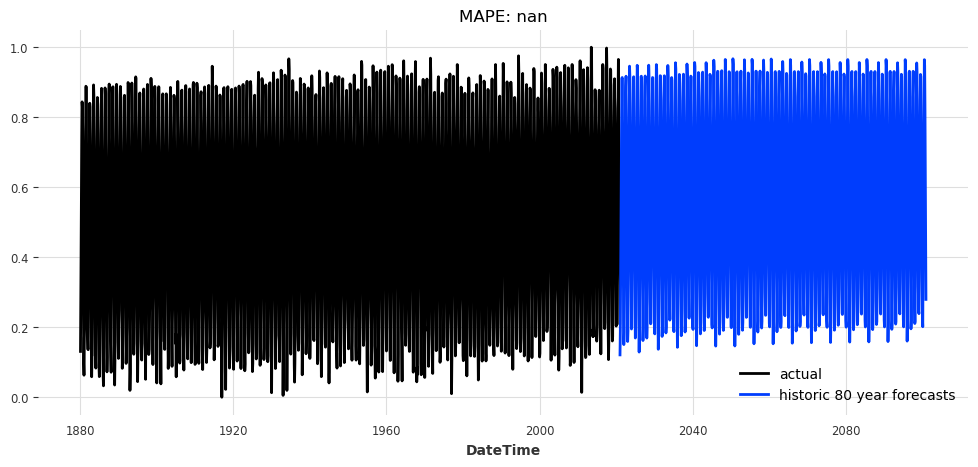

In [15]:
display_forecast(
    pred_series,
    series_scaled,
    "80 year",
    start_date=pd.Timestamp('1880-01-01'),
)

In [16]:
scaler.inverse_transform(series=pred_series).to_csv("a.csv")

In [17]:
forecast = pd.read_csv("a.csv").set_index("DateTime", drop=True)
forecast

,Monthly Anamoly
DateTime,
2021-01-01,3.822407
2021-02-01,5.951168
2021-03-01,10.735882
2021-04-01,16.970810
2021-05-01,22.188820
...,...
2100-08-01,29.880077
2100-09-01,25.844418
2100-10-01,20.118946


In [18]:
rawdata

,Monthly Anamoly
DateTime,
1880-01-01,1.836
1880-02-01,4.134
1880-03-01,8.959
1880-04-01,13.445
1880-05-01,20.229
...,...
2020-08-01,30.436
2020-09-01,24.199
2020-10-01,18.380


In [19]:
total = pd.concat([rawdata, forecast], axis=0)

In [20]:
total.to_csv("./NBEATS_forecast/NBEATS_forecast_shanghai.csv", index=True, header=True)
total

,Monthly Anamoly
DateTime,
1880-01-01 00:00:00,1.836000
1880-02-01 00:00:00,4.134000
1880-03-01 00:00:00,8.959000
1880-04-01 00:00:00,13.445000
1880-05-01 00:00:00,20.229000
...,...
2100-08-01,29.880077
2100-09-01,25.844418
2100-10-01,20.118946


In [21]:
month12_ma = total["Monthly Anamoly"].rolling(window=12).mean()
year10_ma = total["Monthly Anamoly"].rolling(window=120).mean()

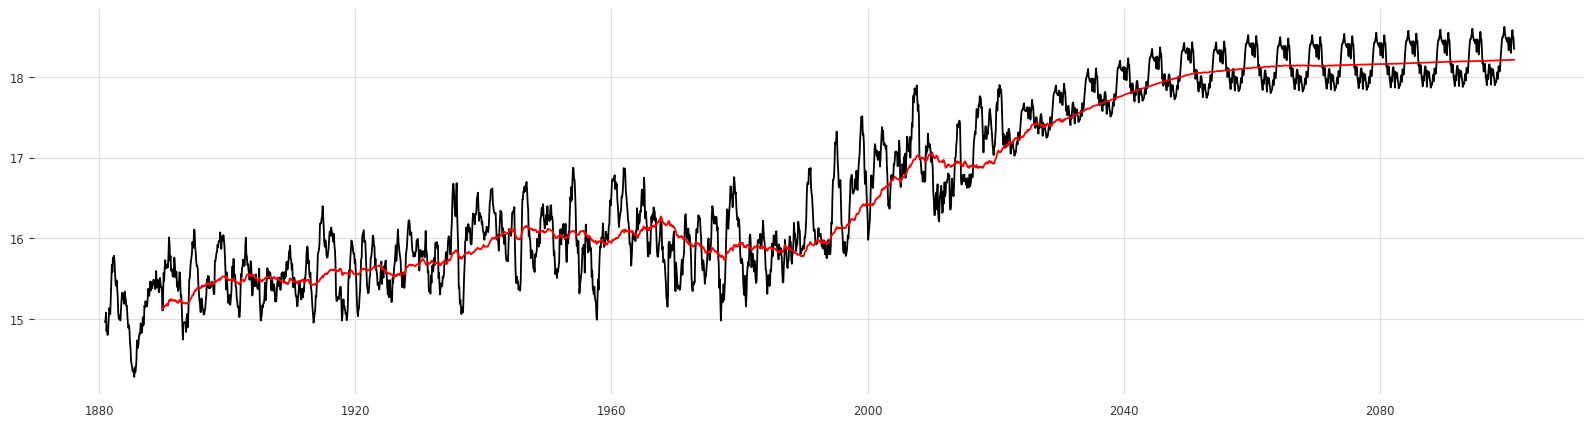

In [22]:
plt.figure(figsize=(20,5))
plt.plot(total.index,month12_ma)
plt.plot(total.index,year10_ma, color='red')